## Task 2 - FitzHugh-Nagumo Model
(6 point)

Read this [Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html) about how to solve higher order differential equations in SciPy.  
The FitzHugh-Nagumo model is described by the following system of differential equations:
$$
\dot{V} = V - \frac{V^3}{3} - W + I
$$
$$
\dot{W} = 0.08(V + a - bW)
$$
where:
- \( V \) is the membrane potential
- \( W \) is a recovery variable
- \( I \) is the magnitude of the stimulus current

a)	Solve the differential equation using ode. Find parameters a,b,I,V0,W0 resulting in a spike train (you can find some examples on [Wikipedia](https://en.wikipedia.org/wiki/FitzHugh%E2%80%93Nagumo_model)). Plot the timeline and the phase plot obtained. You should get something similar: Do not forget to paste your code too

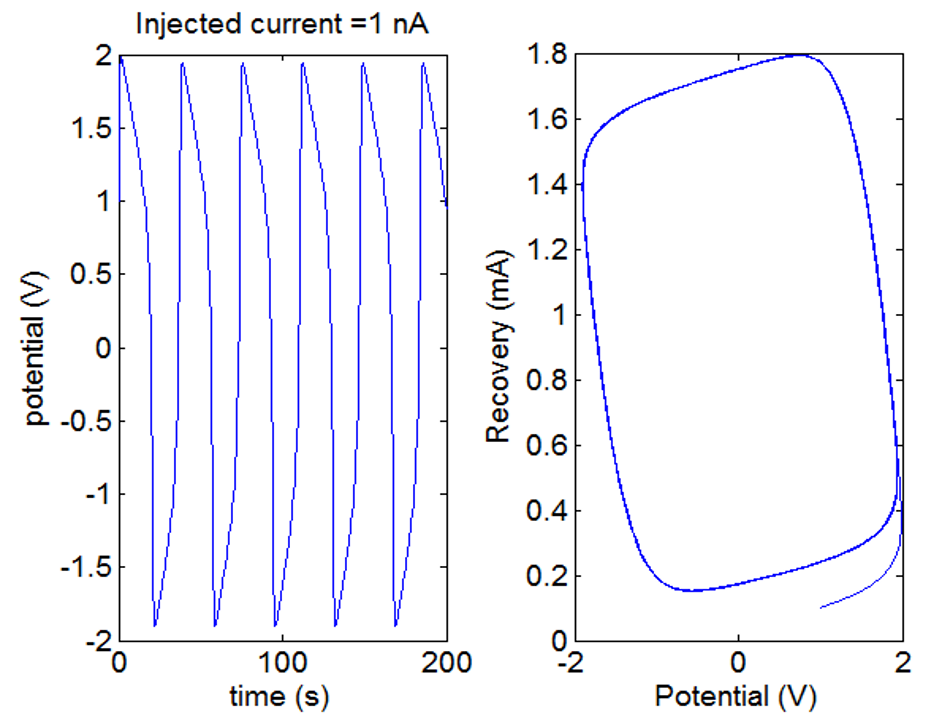

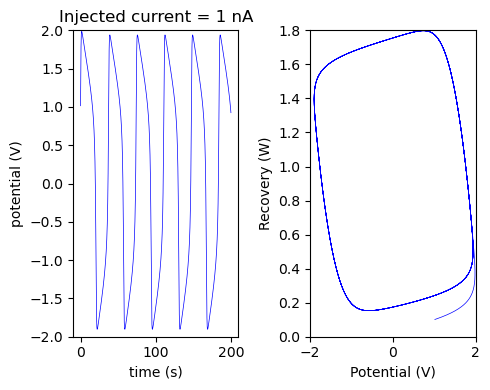

In [87]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd

# Parameters for the FitzHugh-Nagumo model that generate spike trains
a = 0.7
b = 0.8
I_func = lambda x: 1

# Define the system of ODEs
def fitzhugh_nagumo(t, y, a, b, I_func):
    V, W = y
    I = I_func(t)
    dV_dt = V - (V**3)/3 - W + I
    dW_dt = 0.08 * (V + a - b * W)
    return [dV_dt, dW_dt]


# Initial conditions: V0 (membrane potential) and W0 (recovery variable)
V0 = 1
W0 = 0.1
y0 = [V0, W0]

# Create an ODE solver object
solver = ode(fitzhugh_nagumo)
solver.set_f_params(a, b, I_func)
solver.set_initial_value(y0, 0)  # Initial conditions and initial time

# Time range for the solution
t_final = 200
dt = 0.01
t_values = []
V_values = []
W_values = []

# Solve the system over time
while solver.successful() and solver.t < t_final:
    solver.integrate(solver.t + dt)
    t_values.append(solver.t)
    V_values.append(solver.y[0])
    W_values.append(solver.y[1])

# Convert results to arrays for plotting
t_values = np.array(t_values)
V_values = np.array(V_values)
W_values = np.array(W_values)

# Plot the results
plt.figure(figsize=(5, 4))

# Time series plot (left plot)
plt.subplot(1, 2, 1)
plt.plot(t_values, V_values, label="Potential (V)", color="blue", linewidth=0.5)
plt.ylim(-2, 2)
plt.title("Injected current = 1 nA")
plt.xlabel("time (s)")
plt.ylabel("potential (V)")

# Phase plot (right plot)
plt.subplot(1, 2, 2)
plt.plot(V_values, W_values, label="Recovery (W) vs. Potential (V)", color="blue", linewidth=0.5)
plt.ylim(0, 1.8)
plt.xlim(-2, 2)
plt.xlabel("Potential (V)")
plt.ylabel("Recovery (W)")


plt.tight_layout()
plt.show()


b)	Download the first 10s of the signals raw/a1t09 and raw/2t01 from the [Squid Giant Axon Membrane Potential (sgamp) database](https://physionet.org/content/sgamp/1.0.0/).
Plot them (membrane voltage and injected current) in Python. What is the main, visible difference between the 2 recordings?

For the stimulus current channel (2), apply the physical unit conversion, 1V = 5uA/cm2 to get the stimulus current in uA/cm2. 

In [25]:
def parse_info(file_path):
    """
    Parameters:
    - file_path: str, path to the .info file. (DO NOT INCLUDE THE ".info" EXTENSION IN THE file_path!)
    Returns:
    - info: dict, containing parsed metadata.
    """
    info = {}
    # Read the file
    with open(file_path + ".info", 'r') as file:
        file = file.readlines() 
        signals = []
        # Read the fixed information at the beginning
        info['Source'] = file[0].split(':', 1)[1]
        info['Rows'] = int(file[1].split(' ')[2])
        info['Columns'] = int(file[1].split(' ')[6])
        info['Duration'] = file[2].split(':', 1)[1]
        info['Sampling frequency'] = file[3].split('  ')[0].split(':')[1].strip()
        info['Sampling interval'] = file[3].split('  ')[1].split(':')[1].strip()
        # Read the info for each signal
        for line in file[5:-4]:
            signal = {}
            signal['Signal'] = line.split('\t')[1].strip()
            signal['Gain']   = float(line.split('\t')[2].strip())
            signal['Base']   = float(line.split('\t')[3].strip())
            signal['Units']  = line.split('\t')[4].strip()
            signals.append(signal)
        info['Signals'] = signals
    return info

parse_info("a1t09m")

{'Source': ' record sgamp/raw/a1t09\n',
 'Rows': 2,
 'Columns': 1000000,
 'Duration': '     0:08\n',
 'Sampling frequency': '125000 Hz',
 'Sampling interval': '8e-06 sec',
 'Signals': [{'Signal': 'Vmembrane',
   'Gain': 81049.9382,
   'Base': 9133.0,
   'Units': 'V'},
  {'Signal': 'Istim', 'Gain': 22129.2056, 'Base': -2566.0, 'Units': 'V'}]}

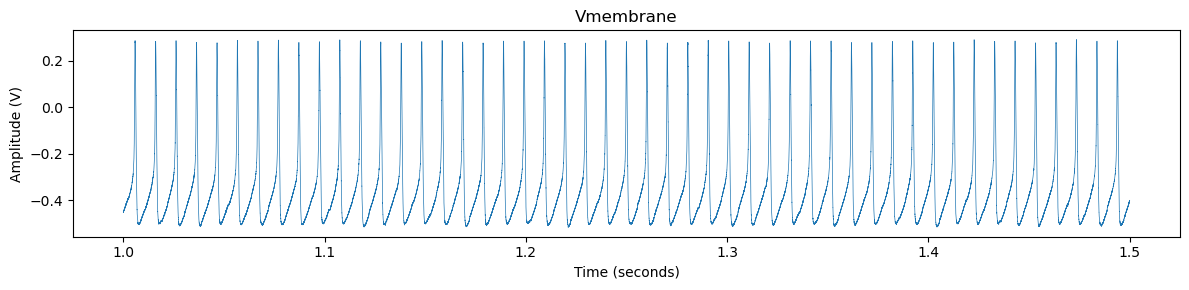

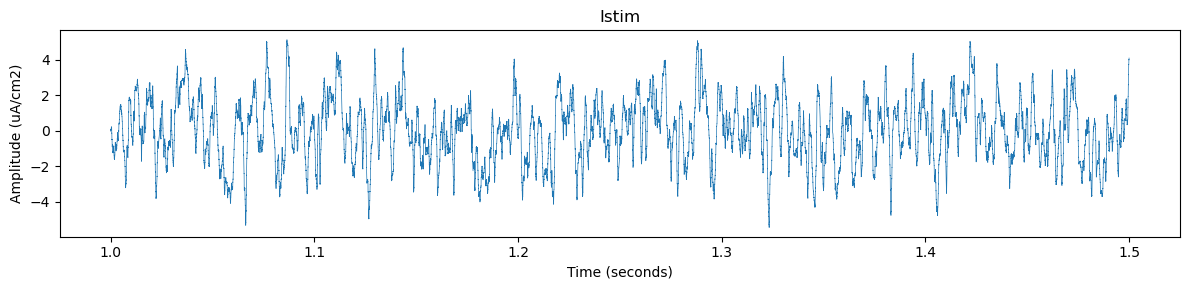

In [90]:
def calibrate_signal(signal, base, gain):
    """
    Parameters:
    - signal: numpy array, the raw signal data.
    - base: float, the baseline offset to subtract.
    - gain: float, the gain factor to apply.
    Returns:
    - calibrated_signal: numpy array, the base and gain corrected signal.
    """
    return (signal - base) / gain

def plot_signals(file_path, info_=False, idx=-1):
    """
    Parameters:
    - file_path: str, path to the .mat file. (DO NOT INCLUDE THE ".mat" EXTENSION IN THE file_path!)
    - info_: bool, is info needs to be displayed. Default is false
    - idx: int, the index of the signal to be shown. -1 for all signals. Default is -1
    """
    mat_data = scipy.io.loadmat(file_path + ".mat")
    info = parse_info(file_path)
    sampling_frequency = int(info['Sampling frequency'][:-3])  # Remove ' Hz' suffix and convert to int
    for idx, signal in enumerate(info["Signals"]):
        raw_signal = mat_data["val"][idx]
        unit = signal["Units"]
        calibrated_signal = calibrate_signal(raw_signal, signal["Base"], signal["Gain"])
        time_axis = np.arange(len(calibrated_signal)) / sampling_frequency  # Create time axis in seconds
        if signal["Signal"] == "Istim":
            unit = "uA/cm2"
            calibrated_signal = calibrated_signal *5
        data = pd.DataFrame({
            'Time': time_axis,
            'Signal': calibrated_signal
        })
        data = data[(data["Time"] <= 1.5) & (data["Time"] >= 1)]
        data.to_csv(f'{file_path}_{signal["Signal"]}.csv', index=False)
        plt.figure(figsize=(12, 3))
        plt.plot(data["Time"], data["Signal"], linewidth=0.5)  # Plot against time
        plt.title(signal["Signal"])
        plt.xlabel("Time (seconds)")
        plt.ylabel(f"Amplitude ({unit})")
        plt.tight_layout()
        plt.show()
plot_signals("a1t09m")

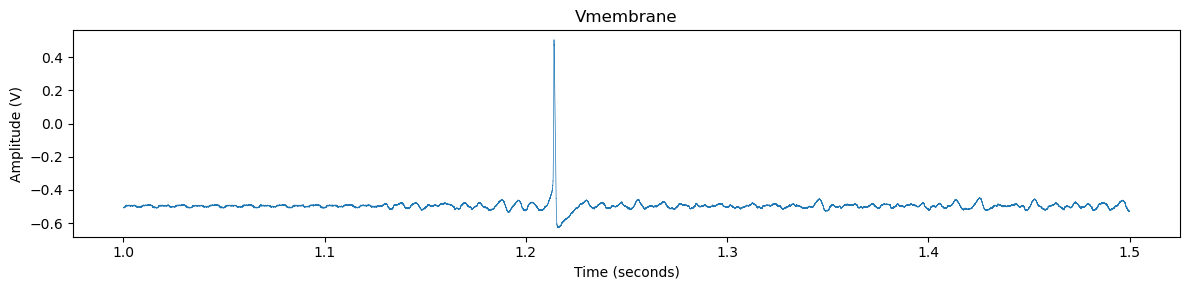

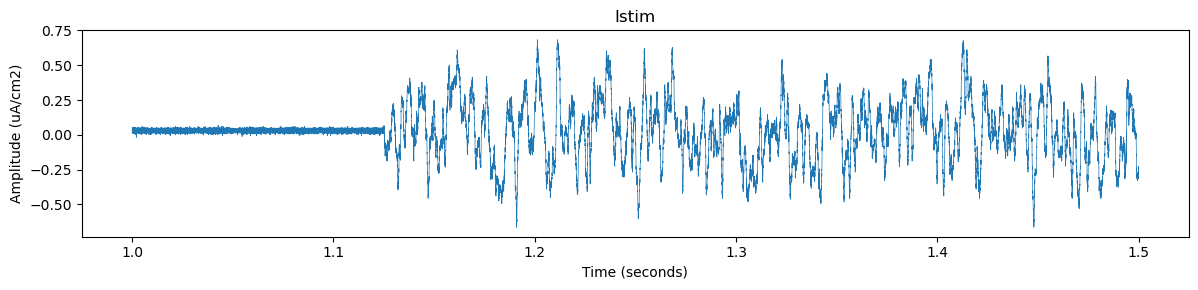

In [91]:
plot_signals("a2t01m")

What is the main, visible difference between the 2 recordings?

It is clearly visible that for the second recording, the membrane potential spikes are less frequent. It can be attributed to slow build-up (charging) and a sudden jump (discharging) which is the case for relaxation oscillators.

c)	Try to simulate this difference with your Fitzhug-Nagumo model. Show your results, and explain, which model did better.

In [92]:
from scipy.interpolate import interp1d
def simulate_fitzhugh_nagumo(filename, a, b, W0):
    voltage_data = pd.read_csv(f'{filename}_Vmembrane.csv')  # Experimental voltage
    current_data = pd.read_csv(f'{filename}_Istim.csv')  # Injected current
    I_func = lambda t: np.interp(t, current_data["Time"], current_data["Signal"]*1000/10) #1000 is for the conversion of nA to uA
    # Initial conditions: V0 (membrane potential) and W0 (recovery variable)
    V0 = voltage_data["Signal"][0]
    y0 = [V0, W0]
    # Create an ODE solver object
    solver = ode(fitzhugh_nagumo)
    solver.set_f_params(a, b, I_func)
    solver.set_initial_value(y0, voltage_data["Time"][0])  # Initial conditions and initial time
    V_sim = []
    W_sim = []
    t_sim = []
    dt = voltage_data["Time"][1] - voltage_data["Time"][0]
    while solver.successful() and solver.t <= voltage_data.iloc[-1, 0]:
        solver.integrate(solver.t + dt)
        t_sim.append(solver.t)
        V_sim.append(solver.y[0])  # Membrane potential (V)
        W_sim.append(solver.y[1])  # Recovery variable (W)
    # Convert results to arrays for plotting
    V_sim = np.array(V_sim)
    W_sim = np.array(W_sim)
    t_sim = np.array(t_sim)
    # Plotting the experimental and simulated membrane potential (voltage)
    plt.figure(figsize=(12, 5))
    plt.subplot(2, 1, 1)
    plt.plot(voltage_data['Time'], voltage_data['Signal'], label='Experimental Voltage', linewidth=0.5)
    plt.plot(t_sim, V_sim, label='Simulated Voltage (FHN)', color='red', linestyle='--', linewidth=0.5)
    plt.title(f"{filename} - Comparison of Experimental and Simulated Membrane Potential")
    plt.ylabel('Membrane Potential (V)')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(t_sim, W_sim, label='Simulated W (Recovery Variable)', color='orange')
    plt.ylabel('Recovery Variable (W)')
    plt.legend()
    plt.tight_layout()
    plt.show()

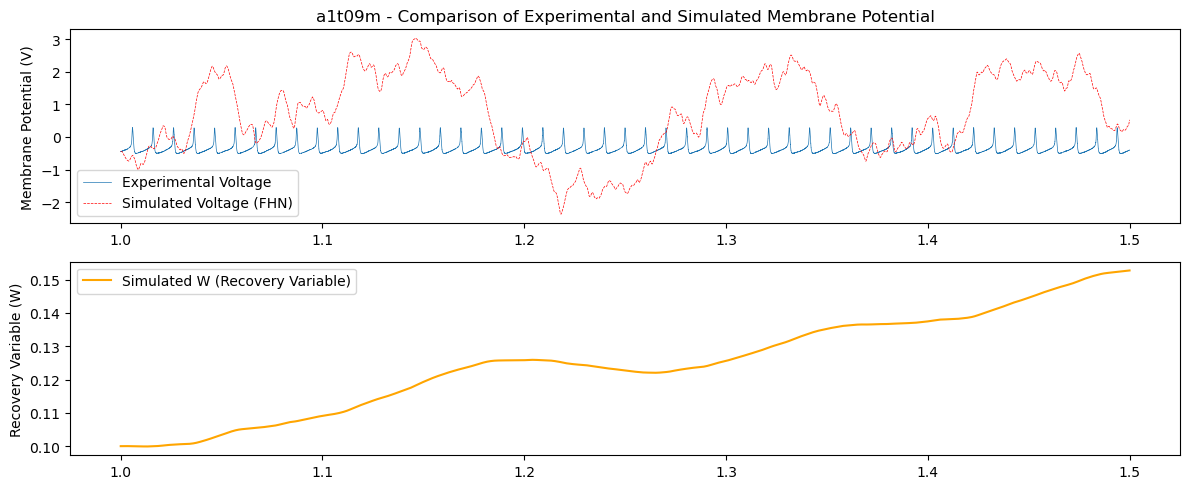

In [93]:
a = 0.7
b = 0.8
W0 = 0.1
simulate_fitzhugh_nagumo("a1t09m", a, b, W0)

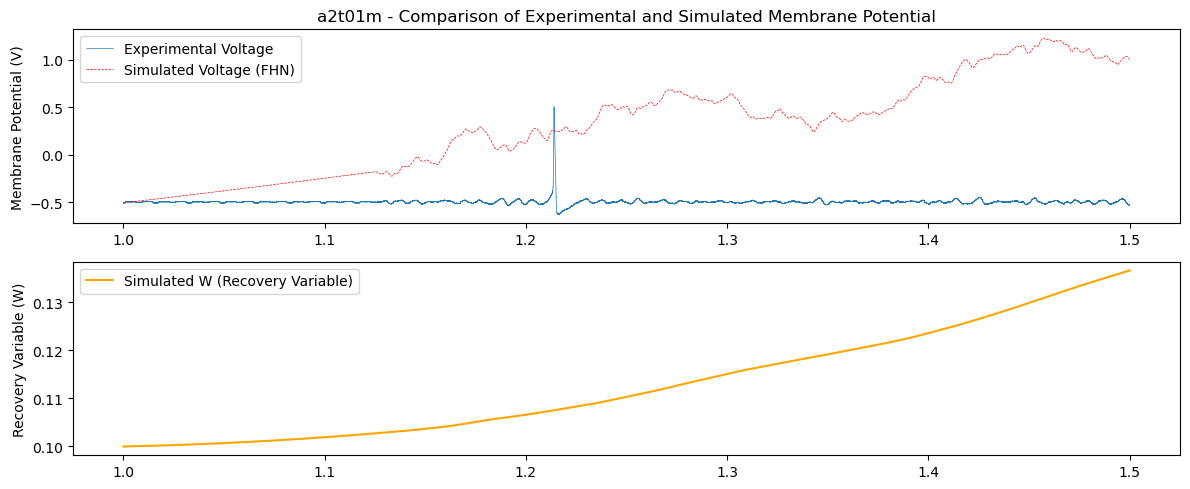

In [94]:
a = 0.7
b = 0.8
W0 = 0.1
simulate_fitzhugh_nagumo("a2t01m", a, b, W0)

1. **a1t09m:**
   - The **experimental voltage** exhibits clear periodic spiking, likely corresponding to action potentials.
   - The **FHN-simulated voltage** does show spiking behavior but differs significantly in amplitude and timing compared to the experimental signal. The FHN model tends to overshoot, showing larger and less regular spikes than the experimental data.

2. **a2t01m:**
   - The **experimental voltage** is much more subdued, with a stable resting potential and only a single sharp spike around 1.2 seconds.
   - The **simulated voltage** using the FHN model, however, shows continuous rising and falling behavior, which doesn't match the flat experimental signal. This suggests that the parameters of the FHN model are not well-tuned for this data set, leading to a mismatch.

At this point, we do not think that any of the simulated Vmembrane has a good performance in terms of similarity with experimental one.

## TASK 3
(3 point)

The following differential equation is given, where x is the input and y is the output:
$$
\ddot{y} + 2ab\dot{y} + b^2y = c\ddot{x}
$$
In the case of discrete systems the derivative will not be the tangential of the curve, but the steepness of the
line connecting the discrete points (difference of the values divided by the time-difference, T).  
For a discrete function $z_n$, the approximations for first and second derivatives are:

1. **First-Order Difference:**  
   The first derivative $\dot{z_n}$ is:
   $$
   \dot{z_n} = \frac{z_{n+1} - z_{n-1}}{2T}
   $$
2. **Second-Order Difference:**  
   The second derivative $\ddot{z_n}$ is:
   $$
   \ddot{z_n} = \frac{\frac{z_{n+1} - z_n}{T} - \frac{z_n - z_{n-1}}{T}}{T}
   $$
   Simplifying, this becomes:
   $$
   \ddot{z_n} = \frac{z_{n+1} - 2z_n + z_{n-1}}{T^2}
   $$


a, Substitute these formulas into the equation above, and multiply it by $T^2$.  
b, Write the difference equation in the form of polynomials, such that:
$$
a \cdot Y = b \cdot X
$$
where:
- $a$ and $b$ are row vectors of coefficients.
- $Y$ and $X$ are column vectors defined as follows:
  - $Y = \begin{bmatrix}
    y_{n+1} \\
    y_n \\
    y_{n-1}
  \end{bmatrix}$

  - $X = \begin{bmatrix}
    x_{n+1} \\
    x_n \\
    x_{n-1}
  \end{bmatrix}$
***What is a transfer function of this system?***

## Solution
### a)
The given differential equation is:
$$
\ddot{y} + 2ab\dot{y} + b^2y = c\ddot{x}
$$
Calculate the derivatives:
   $$
   \ddot{y_n} = \frac{y_{n+1} - 2y_n + y_{n-1}}{T^2}
   $$
   $$
   \dot{y_n} = \frac{y_{n+1} - y_{n-1}}{2T}
   $$
   $$
   \ddot{x_n} = \frac{x_{n+1} - 2x_n + x_{n-1}}{T^2}
   $$

Now, substitute these expressions into the original equation:
$$
\frac{y_{n+1} - 2y_n + y_{n-1}}{T^2} + 2ab \cdot \frac{y_{n+1} - y_{n-1}}{2T} + b^2y_n = c \cdot \frac{x_{n+1} - 2x_n + x_{n-1}}{T^2}
$$
Multiply the entire equation by $ T^2 $:
$$
(y_{n+1} - 2y_n + y_{n-1}) + 2abT \cdot \frac{y_{n+1} - y_{n-1}}{2} + b^2T^2y_n = c(x_{n+1} - 2x_n + x_{n-1})
$$
This simplifies to:
$$
y_{n+1} - 2y_n + y_{n-1} + abT(y_{n+1} - y_{n-1}) + b^2T^2y_n = c(x_{n+1} - 2x_n + x_{n-1})
$$

### b)

We want to rewrite the above equation in the form:
$$
a \cdot Y = b \cdot X
$$
Where $ Y = \begin{bmatrix} y_{n+1} \\ y_n \\ y_{n-1} \end{bmatrix} $ and $ X = \begin{bmatrix} x_{n+1} \\ x_n \\ x_{n-1} \end{bmatrix} $.  
Rewrite and arrange the equation:
$$
y_{n+1}\cdot(1 + abT) + y_n\cdot(-2 + b^2T^2) + y_{n-1}\cdot(1-abT) = x_{n+1}\cdot(c) + x_n\cdot(-2c) + x_{n-1}\cdot(c)
$$
Thus, the equation can be written as:

$$
\begin{bmatrix} 1 + abT & -2 + b^2T^2 & 1 - abT \end{bmatrix}
\cdot
\begin{bmatrix} y_{n+1} \\ y_n \\ y_{n-1} \end{bmatrix}
=
\begin{bmatrix} c & -2c & c \end{bmatrix}
\cdot
\begin{bmatrix} x_{n+1} \\ x_n \\ x_{n-1} \end{bmatrix}
$$

So, we have:
- $ a = \begin{bmatrix} 1 + abT & -2 + b^2T^2 & 1 - abT \end{bmatrix} $
- $ b = \begin{bmatrix} c & -2c & c \end{bmatrix} $

### Transfer Function

To find the transfer function, take the Z-transform of the difference equation. Using the standard Z-transform for sequences, the Z-transform of the delay terms is:
- $ y_{n+1} \to zY(z) $
- $ y_n \to Y(z) $
- $ y_{n-1} \to \frac{Y(z)}{z} $
- Similarly for $ x $ terms.  
The transfer function $ H(z) = \frac{Y(z)}{X(z)} $ is given by:
$$
H(z) = \frac{c(z^2 - 2z + 1)}{(1 + abT)z^2 + (-2 + b^2T^2)z + (1 - abT)}
$$

c) 	In **SciPy** the command *y = lfilter(b_coeff,a_coeff,x)* can solve you this difference equation.  Our input,  x will be a step function.
Complete  the following snippet of code with the right a and b. What biomedical signal does this curve resemble?

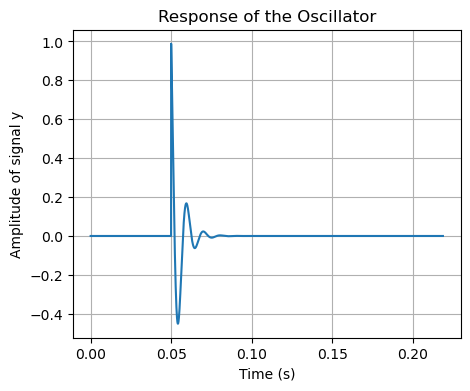

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter
# Parameters
fs = 16e3  # Sampling frequency in Hz
f0 = 100   # Resonant frequency
b = 2 * np.pi * f0  # Resonant angular frequency "b"
a = 0.3    # Damping factor "a"
c = 1      # Gain "c"
T = 1 / fs # Sampling period in s
t = np.linspace(0, 3501 / fs, 3501) # Time of observation
tau = 50e-3 # Time at which step occurs
# Input
x = np.double(t > tau)  # Step input
# Transfer function coefficients
a_coeff = [1 + a*b*T, (b**2)*(T**2)-2, 1 - a*b*T]
b_coeff = [c, -2 * c, c]
# Apply filter
y = lfilter(b_coeff, a_coeff, x)
# Plot the response
plt.figure(figsize=(5, 4))
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude of signal y')
plt.title('Response of the Oscillator')
plt.grid(True)
plt.show()

This signal resembles:
- Action potentials in neurons: where a spike is followed by repolarization and some oscillations before settling to a resting state.
- ECG: After a QRS complex, where a sharp voltage change is followed by smaller oscillations (T-wave, ST segment).

In signal.mat you can find such a signal (structure field signal) and the relating sampling frequency (fs). Find parameters a,b,c and \tau that return a waveform that best matches this signal. You should get a normalised cross-correlation (NXC) of at least 0.6 between the two.  
Use the following code snippet to help you:

1.7207355191746587


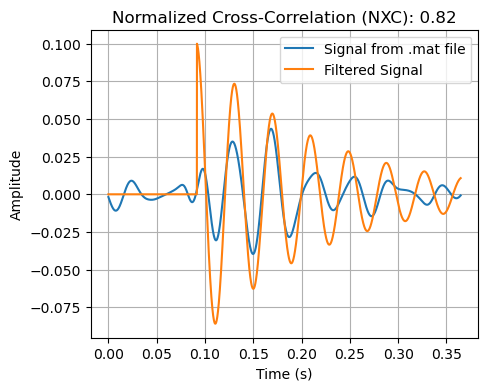

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import norm

# Load the .mat file
mat_data = loadmat('signal.mat')
fs_hrt = mat_data['fs'][0, 0]  # Sampling frequency
y_hrt = mat_data['signal'].flatten()  # Signal
# Time vector for the loaded signal
t_hrt = np.linspace(0, len(y_hrt) / fs_hrt, len(y_hrt))
a=0.05
b=160
tau=0.055
c=0.1
T = 1 / fs_hrt
a_coeff = [1 + a*b*T, (b**2)*(T**2)-2, 1 - a*b*T]
b_coeff = [c, -2 * c, c]
x = np.double(t > tau)
y = lfilter(b_coeff, a_coeff, x)
# Calculate normalized cross-correlation (NXC)
print(norm(y))
NXC = norm(np.sum(y * y_hrt)) / (norm(y) * norm(y_hrt))
# Plot the signals
plt.figure(figsize=(5, 4))
plt.plot(t_hrt, y_hrt, label='Signal from .mat file')
plt.plot(np.linspace(0, len(y) / fs_hrt, len(y)), y, label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title(f'Normalized Cross-Correlation (NXC): {NXC:.2f}')
plt.legend()
plt.grid(True)
plt.show()

Paste below the figure you get, and the parameters you used to generate it. Comment on the parameters you get, and what type of oscillator these define. You are also encouraged to upload an image of the obtained signal and correlation to the forum, so you can help each other, to find the best result.

#### Parameters
- **Resonant angular frequency (b):** This determines the natural frequency of oscillation of the system.
- **Damping factor (a):** This controls how quickly the oscillations die out.
- **Gain (c):** This parameter scales the input signal to produce the desired output amplitude.
- **$\tau$ (time at which step occurs):** Defines the point in time where the step function is applied, affecting the overall shape of the response.

#### Our parameters that best fit:
- **Damping factor $ a = 0.05 $**: This is a relatively low damping factor, indicating that the system is **underdamped**. In an underdamped system, we expect to see oscillations that gradually decay over time. This behavior is often seen in systems where energy loss (due to friction, resistance, etc.) is minimal, and the system can sustain oscillations for a period before settling.
  
- **Resonant angular frequency $b = 160$**: The high value of b corresponds to a fast oscillatory system. This relatively high frequency suggests that the system oscillates quickly.

- **Step time $ \tau = 0.055 $ s**: This specifies the time at which the step input is applied. It determines when the system begins to respond

- **Gain $c = 0.1$**: The gain scales the input, allowing the system to respond proportionally to the amplitude of the step input. A low gain indicates that the system output is scaled down, preventing large oscillations in the output signal.

The parameters define a damped harmonic oscillator.

# Lecture Notes
## Week 2
### Heart Model
Heart can be modeled as a simple pump. A wheel can generate a constant pressure difference in a pipe, causing liquid to flow. However, there are many dissimilarities with the actual functionality of the heart. 
- In mammals, the heart has two pumps - left and right one for the lungs and the other for the rest of the body.
- Non uniform cross section: Arteries are much thicker than capillaries. Cross section gets smaller and smaller as the blood flows.
- Non rigid veins and arteries.
- Blood leakage: Some blood collects waste from cells and collects it in the lymphatic system.
- Non uniform pressure gradient due to pumping and the elasticity of the heart.

<img src="https://humanap.community.uaf.edu/wp-content/uploads/sites/848/2023/04/Screenshot-2023-04-20-at-11.12.24-PM-768x583.png" style="width: 30%;"/>

*https://humanap.community.uaf.edu/2023/04/20/the-path-of-blood-through-the-heart-and-circulatory-system/*


### Blood Pressure Signals
As the ventricle contracts, the blood pressure goes up and there is a peak. As the amount of blood drops, the pressure decreases. The walls of the veins flap between systolic and diastolic pressure. As the semilunar valves are closing and the blood flows towards the veins, some pressure is reflected due to the narrowness of the veins and blood flows back towards the closed valved causing the dicrotic notch. Veins get stiffer with age so in young people the dicrotic notch is more prominent.

#### Measurement of Blood Pressure

Apply pressure on the upper arm or wrists using a cuff to close the veins and listen to the sound produced to measure the blood pressure. Electronic measurement devices use the same methodology.

### Origin of Heart Sound
Caused by the opening and closing of valves.  
**S1:** Atrioventricular valves close - *lub* sound  
**S2:** Semilunar values close - *dub* sound  
More sounds may indicate a pathology. The heart rate signal visibly shifts when you breathe. 

### Photoplethysmography (PPG)
It is a measurement of optical signals coming from the heart. An LED is used as a light source to lighten the veins. A receiver measures the amount of reflected light. As the heart cycle changes, there will be more or less blood flowing, changing the amount of reflected light. It can be measured from either the wrist or the fingertip but in that case the light source is on one side and the detector on the other side of the finger.

### Pulse Oximetry
2 LEDs of different frequencies are absorbed differently in tissues. In oxygenated blood, red light is measured in a lower ratio. In deoxygenated blood, more red light is absorbed. Pulse oximetry helps calculate oxygenated vs deoxygenated blood ratio.

### Electric signals in the body
Our neurons have electricity. There is negative charge inside the cell and positive charge outside it.

<img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Apshoot.jpg" style="width: 30%;"/>

*By <a class="external free" href="https://en.wikipedia.org/wiki/User:Memenen">http://en.wikipedia.org/wiki/User:Memenen</a> - <a class="external free" href="https://en.wikipedia.org/wiki/File:Apshoot.jpg">http://en.wikipedia.org/wiki/File:Apshoot.jpg</a>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=10516286">Link</a>*

An action potential travels down an axon as ions move through ion channels. In unmyelinated axons, this process is slower because the signal moves continuously. In myelinated axons, the signal propagates quicker.  
Electric signals can be measured on the surface of the body. Potential difference between two points in the body can be measured by electrodes. 

#### Heart Dipole Model
To contract the muscles we need electricity generated by cells in the heart. Potential difference between any two points is depicted as a dipole. 

#### PQRST Complex

In an ECG, the P wave shows atrial depolarization. The QRS complex shows ventricular depolarization and the T wave shows ventricular repolarization. 

#### ECG 12 Lead System
Electrodes are placed on the chest, wrists and ankles and between two electrodes a signal is measured. 12 different waveforms from different directions are measured, giving insights onto how the heart is working. 

<img src="https://www.researchgate.net/publication/371052743/figure/fig1/AS:11431281210492387@1702046732241/ECG-electrode-placement-The-name-and-placement-of-the-standard-ten-electrodes-used-to.tif" style="width: 30%;"/>

Source: [ResearchGate](https://www.researchgate.net/figure/ECG-electrode-placement-The-name-and-placement-of-the-standard-ten-electrodes-used-to_fig1_371052743) [accessed 22 Sept 2024].

##### Vectorcardiography
We don't actually need 12 signals. In theory, 3 different measurements are sufficient. One signal can be made as a combination of other signals. The 12 lead system is just too established.   
If signals are measured from orthogonal directions, signals will be orthogonal too usually. 

#### Action Potential
An action potential is an electrical signal that travels along cells, allowing them to send messages efficiently.

##### Pacemaker potential
Pacemaker potential is the slow increase in electrical charge in heart cells, which triggers the heartbeat.

##### Field potential
A field potential is the overall electrical signal from a group of cells, showing the combined effect of their individual signals.

#### EEG

##### EEG Dipole Model
Pyramidal cells are the most common type of cells in the brain, named after their shape. Pyramidal cells are oriented perpendicular to the surface of the cortex.

##### 10/20 System
A standardized method for placing EEG electrodes on the scalp, ensuring consistent, accurate measurement. 10 and 20 refer to the percentage distances between adjacent electrodes, based on the size of the head.

##### Examples of EEG Signals [3]
- **Alpha waves (8-13 Hz)**: Present during relaxed wakefulness with closed eyes.
- **Beta waves (13-30 Hz)**: Associated with active thinking and focus.
- **Theta waves (4-8 Hz)**: Common during light sleep or deep relaxation.
- **Delta waves (0.5-4 Hz)**: Dominant in deep sleep stages.
- **Gamma waves (>30 Hz)**: Linked to high-level cognitive functioning.

[3] Niedermeyer, E., & da Silva, F. L. (2004). *Electroencephalography: Basic Principles, Clinical Applications, and Related Fields* (5th ed.). Lippincott Williams & Wilkins.

#### Motor Units

A Motor Unit Action Potential (MUAP) is generated when a motor unit fires. Motor unit recruitment refers to how multiple MUs are activated to increase force by either spatial recruitment (more units) or temporal recruitment (increased firing rate). Pathologies affecting motor units can alter these patterns. [4]

Gazzaniga, M. S., Ivry, R., & Mangun, G. R. (2018). Cognitive Neuroscience: The Biology of the Mind (5th ed.). W.W. Norton & Company.

## Week 3 - Signal Genesis Equations

### The Mathematics of Linear Oscillations

Oscillations refer to the repetitive variation of some quantity around an equilibrium point, characterized by frequency and phase.  
**Examples of Oscillations**:
- **Biomedical**: Heartbeat, gait cycle, circadian rhythm, menstrual cycle, ECG signals.
- **Physics**: Motion of a spring, pendulum oscillations.

#### Simple Oscillator: Mass-Spring-Damper System

The motion of a mass-spring system is modelled using a differential equation:
$$
m \frac{d^2x(t)}{dt^2} + kx(t) = 0
$$
Where:
- $m$ is the mass of the object,
- $x(t)$ is the displacement from the equilibrium position as a function of time $t$,
- $k$ is the spring constant.  
There are two methods to solve this equation:
1. **Using a Probe Function:**

   Assume the solution takes the form $x(t) = A e^{st}$. Differentiating this function:

   $$
   \frac{dx(t)}{dt} = s A e^{st}, \quad \frac{d^2x(t)}{dt^2} = s^2 A e^{st}
   $$

   Substitute into the original equation and solve for $s$.

2. **Using the Laplace Transform:**

   The Laplace transform can convert the differential equation into an algebraic equation, making it easier to solve in the frequency domain.

**Fourier vs Laplace Transform**:
- **Laplace transform** applies to complex values and is defined over the entire complex plane.
- **Fourier transform** deals with real-valued signals and is only defined along the imaginary axis $j\omega$.

##### I/O Model (Input-Output)

The equation for a damped oscillator can be written as:

$$
m \ddot{x}(t) + c \dot{x}(t) + k x(t) = B f(t)
$$

Where:
- $c$ is the damping coefficient,
- $f(t)$ is the applied force,
- $B$ is a constant related to the gain.

##### Transfer Function

The transfer function $G(s)$ relates the output $X(s)$ to the input $F(s)$ in the Laplace domain:

$$
G(s) = \frac{X(s)}{F(s)} = \frac{B/m}{s^2 + \frac{c}{m}s + \frac{k}{m}}
$$

- **Zeros**: The points where the numerator equals zero.
- **Poles**: The points where the denominator equals zero. For system stability, poles must be in the left half of the complex plane.

#### Stability

- **Undamped System** $(c = 0)$:
  In an undamped system, the solution takes the form:
  $$
  x(t) = A_1 e^{s_1 t} + A_2 e^{s_2 t}
  $$
  At resonant frequencies, the amplitude can theoretically increase to infinity.

- **Overdamped System** $(c > 2\sqrt{mk})$:
  In overdamped systems, the response decays exponentially without oscillations. External forces applied at a frequency different from the natural frequency result in a finite response.  
  
**Significance**: The mass-spring-damper model can be used to simulate heart sounds (S2) [1].

### Nonlinear Oscillations

Nonlinear systems can model more complex biomedical systems.

#### Duffing Oscillator

The Duffing oscillator adds nonlinearity to the equation through a cubic term:

$$
\ddot{x} + \alpha \dot{x} + \beta x + \gamma x^3 = \delta \cos(\omega t)
$$

In a physical representation, a magnet introduces the non-linearity.

**Example**: The S2 heart sound can be modeled by a Duffing oscillator [2].

#### Van der Pol Oscillator

The Van der Pol oscillator, often used to model neural activity, is given by:

$$
\ddot{x} - \mu (1 - x^2) \dot{x} + x = 0
$$

It performs a limit cycle oscillation, which means the system will oscillate even without an external periodic force after an initial push. This is similar to how defibrillators jump the heart [3].

#### Relaxation Oscillators

Relaxation oscillators are characterized by a slow build followed by a rapid jump, similar to the action potential in neurons after reaching a threshold.

### Coupling of Oscillators

In linear systems, oscillators can be coupled by adding terms. Coupled systems are described by a set of differential equations. In biology and physics, coupling is important in systems like:

- Neurons,
- Cardiovascular-respiratory coupling (interaction between heart rate and respiration),
- Turbulent airflows.

The **Kuramoto model** describes synchronization of coupled oscillators and can be applied to model biological rhythms where synchronization plays a role [4].

### EEG as a Multiscale Event

In EEG signals, only the lower frequencies (e.g., delta, theta, alpha waves) are measurable from the complex electrical activity happening in the brain. Higher frequency signals are often filtered out [5].

### Pair Synchronization

A minimum level of coupling is necessary to achieve synchronization between oscillators. This concept is essential in modeling biological systems where synchronization occurs, such as heart cells or neurons firing.

### Small-World Networks in EEG

The neurons in our brain are highly clustered but even then, distant regions are connected very efficiently. This allows for quick synchronization and efficient information transmission, which is essential for cognition [6].

### Filtering in the Brain

There is a filtering process in the brain too. It only processes relevant information while filtering out any unnecessary stimuli. This is especially noticeable in the sleep state, where there is an increased emphasis on filtering sensory input [7].

### References

[1] Cohen, D., & Cavanagh, P. (2011). *EEG and Human Brain Dynamics*. Wiley-Blackwell.  
[2] Hall, S. J. (2017). *Electromyography and Neuromuscular Disorders: A Practical Guide*. Elsevier.  
[3] Gazzaniga, M. S., Ivry, R., & Mangun, G. R. (2018). *Cognitive Neuroscience: The Biology of the Mind* (5th ed.). W.W. Norton & Company.  
[4] Strogatz, S. H. (2001). *Exploring Complex Networks*. Nature, 410(6825), 268-276.  
[5] Niedermeyer, E., & da Silva, F. L. (2004). *Electroencephalography: Basic Principles, Clinical Applications, and Related Fields* (5th ed.). Lippincott Williams & Wilkins.  
[6] Watts, D. J., & Strogatz, S. H. (1998). *Collective dynamics of ‘small-world’ networks*. Nature, 393(6684), 440-442.  
[7] Kandel, E. R., Schwartz, J. H., & Jessell, T. M. (2000). *Principles of Neural Science* (4th ed.). McGraw-Hill.
